In [53]:
import pandas as pd
import numpy as np
from math import sqrt
import pickle

#from io import BytesIO
#from io import StringIO
#mport boto3

import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
random_state = 5

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import shap

from statsmodels.stats.outliers_influence import variance_inflation_factor

#adjust view
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

### Background && Explanation of intent

In [26]:
"""
This notebook is to explore trying to correctly classify which football team will win based on team statitics alone.

## data source is coming from https://www.espn.com/nfl/scoreboard/

statistics included in model:
-----------------------------------------------------
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   first_downs_away              4628 non-null   int64  
 1   first_downs_home              4628 non-null   int64  
 2   passing_yards_away            4628 non-null   int64  
 3   passing_yards_home            4628 non-null   int64  
 4   rushing_yards_away            4628 non-null   int64  
 5   rushing_yards_home            4628 non-null   int64  
 6   total_yards_away              4628 non-null   int64  
 7   total_yards_home              4628 non-null   int64  
 8   rushing_attempts_away         4628 non-null   int64  
 9   rushing_attempts_home         4628 non-null   int64  
 10  fumbles_away                  4628 non-null   int64  
 11  fumbles_home                  4628 non-null   int64  
 12  int_away                      4628 non-null   int64  
 13  int_home                      4628 non-null   int64  
 14  turnovers_away                4628 non-null   int64  
 15  turnovers_home                4628 non-null   int64  
 16  drives_away                   4628 non-null   int64  
 17  drives_home                   4628 non-null   int64  
 18  def_st_td_away                4628 non-null   int64  
 19  def_st_td_home                4628 non-null   int64  
 20  possession_away               4628 non-null   float64
 21  possession_home               4628 non-null   float64
 22  third_down_conversion         4628 non-null   float64
 23  third_downs_home_conversion   4628 non-null   float64
 24  fourth_downs_away_conversion  4628 non-null   float64
 25  fourth_downs_home_conversion  4628 non-null   float64
 26  comp_att_away_conversion      4628 non-null   float64
 27  comp_att_home_conversion      4628 non-null   float64
 28  sacks_away_occur              4628 non-null   int32  
 29  sacks_away_yards              4628 non-null   int32  
 30  sacks_home_occur              4628 non-null   int32  
 31  sacks_home_yards              4628 non-null   int32  
 32  penalties_away_occur          4628 non-null   int32  
 33  penalties_away_yards          4628 non-null   int32  
 34  penalties_home_occur          4628 non-null   int32  
 35  penalties_home_yards          4628 non-null   int32  
 36  target                        4628 non-null   int32  
dtypes: float64(8), int32(9), int64(22)
memory usage: 1.2 MB

"""

'\nThis notebook is to explore trying to correctly classify which football team will win based on team statitics alone.\n\n## data source is coming from https://www.espn.com/nfl/scoreboard/\n\nstatistics included in model:\n-----------------------------------------------------\nData columns (total 39 columns):\n #   Column                        Non-Null Count  Dtype  \n---  ------                        --------------  -----  \n 0   first_downs_away              4628 non-null   int64  \n 1   first_downs_home              4628 non-null   int64  \n 2   passing_yards_away            4628 non-null   int64  \n 3   passing_yards_home            4628 non-null   int64  \n 4   rushing_yards_away            4628 non-null   int64  \n 5   rushing_yards_home            4628 non-null   int64  \n 6   total_yards_away              4628 non-null   int64  \n 7   total_yards_home              4628 non-null   int64  \n 8   rushing_attempts_away         4628 non-null   int64  \n 9   rushing_attempts_home 

In [27]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('data/cleaned_games.csv')
df['target_class']  = np.where(df['target'] == 1, "away", "home")
print(df.groupby('target_class').size())
df = df.drop(columns = ['Unnamed: 0', 'target', 'score_home', 'score_away'])
df.head()

target_class
away    1977
home    2651
dtype: int64


,first_downs_away,first_downs_home,passing_yards_away,passing_yards_home,rushing_yards_away,rushing_yards_home,total_yards_away,total_yards_home,rushing_attempts_away,rushing_attempts_home,fumbles_away,fumbles_home,int_away,int_home,turnovers_away,turnovers_home,drives_away,drives_home,def_st_td_away,def_st_td_home,possession_away,possession_home,third_down_conversion,third_downs_home_conversion,fourth_downs_away_conversion,fourth_downs_home_conversion,comp_att_away_conversion,comp_att_home_conversion,sacks_away_occur,sacks_away_yards,sacks_home_occur,sacks_home_yards,penalties_away_occur,penalties_away_yards,penalties_home_occur,penalties_home_yards,target_class
0,13,21,166,318,113,43,279,361,25,22,0,0,1,3,1,3,13,15,0,0,27.32,32.28,0.333333,0.562500,0.0,0.0,0.615385,0.622222,0,0,3,24,5,29,10,80,away
1,18,26,193,242,73,142,266,384,14,32,1,1,0,2,1,3,17,18,2,0,21.06,39.08,0.250000,0.411765,0.0,1.0,0.800000,0.666667,3,17,4,29,10,90,10,82,away
2,19,20,228,288,140,80,368,368,33,26,1,1,2,1,3,2,17,17,0,0,31.31,28.29,0.384615,0.538462,0.0,0.0,0.571429,0.606061,1,6,1,9,8,52,4,33,home
3,27,13,160,167,241,36,401,203,45,13,0,0,0,1,0,1,11,15,0,0,37.48,22.12,0.600000,0.363636,0.0,0.0,0.789474,0.580645,1,0,4,31,4,39,9,57,away
4,24,24,276,352,194,59,470,411,30,20,0,1,1,0,1,1,20,17,0,0,30.16,29.44,0.454545,0.363636,0.0,0.0,0.689655,0.700000,0,0,1,7,9,87,4,38,away


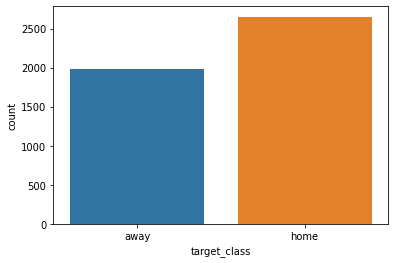

In [28]:
sns.countplot(x='target_class', data=df)
plt.show()

In [29]:
df.groupby('target_class').mean()

,first_downs_away,first_downs_home,passing_yards_away,passing_yards_home,rushing_yards_away,rushing_yards_home,total_yards_away,total_yards_home,rushing_attempts_away,rushing_attempts_home,fumbles_away,fumbles_home,int_away,int_home,turnovers_away,turnovers_home,drives_away,drives_home,def_st_td_away,def_st_td_home,possession_away,possession_home,third_down_conversion,third_downs_home_conversion,fourth_downs_away_conversion,fourth_downs_home_conversion,comp_att_away_conversion,comp_att_home_conversion,sacks_away_occur,sacks_away_yards,sacks_home_occur,sacks_home_yards,penalties_away_occur,penalties_away_yards,penalties_home_occur,penalties_home_yards
target_class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
away,20.350531,18.376834,227.769853,220.389479,132.164896,96.015175,359.934750,316.404654,31.713202,22.870511,0.448660,0.839656,0.563986,1.361153,1.012645,2.200809,12.388467,12.479514,0.569044,0.181588,31.892701,28.165771,0.420428,0.344611,0.277390,0.293298,0.639554,0.582881,1.758220,10.835104,2.805260,18.385938,6.373799,53.527061,6.495195,54.157815
home,17.621652,20.823840,214.110902,231.185590,93.009430,134.066390,307.120332,365.251980,22.788382,31.525462,0.816296,0.512260,1.295737,0.584685,2.112033,1.096945,12.553376,12.342889,0.181064,0.510751,28.161916,31.880392,0.337439,0.423287,0.300224,0.278448,0.582136,0.645082,2.789513,18.550358,1.751415,11.101471,6.747642,55.915126,5.993965,50.121086


In [30]:
df.corr()

,first_downs_away,first_downs_home,passing_yards_away,passing_yards_home,rushing_yards_away,rushing_yards_home,total_yards_away,total_yards_home,rushing_attempts_away,rushing_attempts_home,fumbles_away,fumbles_home,int_away,int_home,turnovers_away,turnovers_home,drives_away,drives_home,def_st_td_away,def_st_td_home,possession_away,possession_home,third_down_conversion,third_downs_home_conversion,fourth_downs_away_conversion,fourth_downs_home_conversion,comp_att_away_conversion,comp_att_home_conversion,sacks_away_occur,sacks_away_yards,sacks_home_occur,sacks_home_yards,penalties_away_occur,penalties_away_yards,penalties_home_occur,penalties_home_yards
first_downs_away,1.000000,-0.101036,0.651866,0.073988,0.385061,-0.214030,0.822134,-0.064052,0.360270,-0.435169,-0.033908,-0.066163,-0.068044,-0.028853,-0.072727,-0.061868,-0.115038,-0.112492,-0.073294,0.015840,0.595730,-0.551493,0.558393,-0.060610,0.113965,-0.012735,0.428009,-0.026545,-0.191575,-0.180054,0.017344,0.021229,0.009636,0.046889,0.094827,0.088656
first_downs_home,-0.101036,1.000000,0.078488,0.631828,-0.202208,0.338504,-0.047162,0.797499,-0.386343,0.329185,-0.037070,-0.016919,-0.026089,-0.070421,-0.042523,-0.063337,-0.086518,-0.099405,0.029875,-0.086159,-0.506998,0.562448,-0.071233,0.514465,-0.019530,0.112409,-0.021029,0.417914,-0.037191,-0.017857,-0.202248,-0.191774,0.088688,0.102967,0.004261,0.025714
passing_yards_away,0.651866,0.078488,1.000000,0.180410,-0.168325,-0.067211,0.814920,0.126011,-0.143394,-0.193939,0.009692,-0.089952,-0.000209,-0.070014,0.005735,-0.107316,-0.041280,-0.043221,-0.088808,0.040706,0.257041,-0.221855,0.363936,0.036157,0.046171,0.007741,0.446010,0.058109,-0.209888,-0.201705,-0.020400,-0.015187,0.088184,0.104277,-0.014676,-0.021915
passing_yards_home,0.073988,0.631828,0.180410,1.000000,-0.047575,-0.216231,0.136902,0.795489,-0.160077,-0.166266,-0.074135,0.033614,-0.083007,-0.001454,-0.108650,0.019287,-0.031586,-0.026533,0.057290,-0.086585,-0.188070,0.230768,0.014431,0.336265,-0.006305,0.047700,0.075873,0.423272,-0.062057,-0.045891,-0.193261,-0.196878,-0.010531,0.004151,0.086140,0.099854
rushing_yards_away,0.385061,-0.202208,-0.168325,-0.047575,1.000000,-0.246175,0.434132,-0.197019,0.764764,-0.404624,-0.081407,0.056648,-0.159404,0.153433,-0.171573,0.149997,-0.014008,0.019975,0.049553,-0.057233,0.472509,-0.433539,0.273944,-0.183159,0.039281,-0.005108,0.033740,-0.181075,-0.185722,-0.197097,0.123505,0.121202,-0.018698,0.005006,-0.025850,-0.035713
rushing_yards_home,-0.214030,0.338504,-0.067211,-0.216231,-0.246175,1.000000,-0.206165,0.419623,-0.371153,0.739852,0.060607,-0.069870,0.125845,-0.173716,0.133225,-0.173302,0.031107,-0.006881,-0.079944,0.022962,-0.401162,0.425805,-0.183644,0.237385,-0.019146,0.027027,-0.203280,0.041238,0.085765,0.089019,-0.212679,-0.209303,-0.074756,-0.092555,-0.020086,-0.011457
total_yards_away,0.822134,-0.047162,0.814920,0.136902,0.434132,-0.206165,1.000000,-0.000679,0.318606,-0.415142,-0.039007,-0.048899,-0.093914,0.026228,-0.095638,-0.009883,-0.045961,-0.027754,-0.052025,0.003550,0.512725,-0.457656,0.493666,-0.074647,0.065290,0.004071,0.427441,-0.053360,-0.301012,-0.300222,0.053973,0.057383,0.069597,0.098241,-0.028611,-0.041026
total_yards_home,-0.064052,0.797499,0.126011,0.795489,-0.197019,0.419623,-0.000679,1.000000,-0.379180,0.304614,-0.031307,-0.012114,0.000934,-0.109170,-0.018325,-0.089629,-0.010058,-0.028939,0.003645,-0.066247,-0.423830,0.478820,-0.100563,0.459957,-0.017744,0.061120,-0.055627,0.419107,-0.004464,0.012586,-0.311673,-0.312940,-0.056188,-0.053585,0.067618,0.085722
rushing_attempts_away,0.360270,-0.386343,-0.143394,-0.160077,0.764764,-0.371153,0.318606,-0.379180,1.000000,-0.576480,-0.112918,0.165904,-0.243378,0.265719,-0.255040,0.300881,0.030138,0.069616,0.097509,-0.072281,0.700712,-0.650908,0.336874,-0.339787,0.041181,-0.024900,0.101494,-0.341238,-0.252150,-0.269237,0.215593,0.207742,-0.064534,-0.034371,-0.006918,-0.020191
rushing_attempts_home,-0.435169,0.329185,-0.193939,-0.166266,-0.404624,0.739852,-0

In [31]:
df.head()

,first_downs_away,first_downs_home,passing_yards_away,passing_yards_home,rushing_yards_away,rushing_yards_home,total_yards_away,total_yards_home,rushing_attempts_away,rushing_attempts_home,fumbles_away,fumbles_home,int_away,int_home,turnovers_away,turnovers_home,drives_away,drives_home,def_st_td_away,def_st_td_home,possession_away,possession_home,third_down_conversion,third_downs_home_conversion,fourth_downs_away_conversion,fourth_downs_home_conversion,comp_att_away_conversion,comp_att_home_conversion,sacks_away_occur,sacks_away_yards,sacks_home_occur,sacks_home_yards,penalties_away_occur,penalties_away_yards,penalties_home_occur,penalties_home_yards,target_class
0,13,21,166,318,113,43,279,361,25,22,0,0,1,3,1,3,13,15,0,0,27.32,32.28,0.333333,0.562500,0.0,0.0,0.615385,0.622222,0,0,3,24,5,29,10,80,away
1,18,26,193,242,73,142,266,384,14,32,1,1,0,2,1,3,17,18,2,0,21.06,39.08,0.250000,0.411765,0.0,1.0,0.800000,0.666667,3,17,4,29,10,90,10,82,away
2,19,20,228,288,140,80,368,368,33,26,1,1,2,1,3,2,17,17,0,0,31.31,28.29,0.384615,0.538462,0.0,0.0,0.571429,0.606061,1,6,1,9,8,52,4,33,home
3,27,13,160,167,241,36,401,203,45,13,0,0,0,1,0,1,11,15,0,0,37.48,22.12,0.600000,0.363636,0.0,0.0,0.789474,0.580645,1,0,4,31,4,39,9,57,away
4,24,24,276,352,194,59,470,411,30,20,0,1,1,0,1,1,20,17,0,0,30.16,29.44,0.454545,0.363636,0.0,0.0,0.689655,0.700000,0,0,1,7,9,87,4,38,away


# Modeling

In [32]:
data_bucket = df.copy()
data_bucket = data_bucket.dropna()
data_len = len(data_bucket.columns)

y_adj_bucket = data_bucket.iloc[:,data_len-1:]
X_adj_bucket = data_bucket.iloc[:,:data_len-1]

In [ ]:
## histograms

tags=list(X_adj_bucket.columns)

for tag in tags:
    fig1 = plt.figure()
    plt.hist(X_adj_bucket[tag], label = tag)
    plt.xlabel(tag,fontsize=12)
    plt.ylabel("Freq",fontsize=12)
#         plt.legend( loc='lower center', bbox_to_anchor=(0.5, -.4)) #, bbox_to_anchor=(0.5, -.5)
    plt.show()

## Model Type - Random Forest

In [60]:
rf_clf =RandomForestClassifier(max_depth = 6,n_estimators=10, max_features = 'log2', random_state=0)
#rf_clf =RandomForestClassifier(max_depth = 6,n_estimators=10, max_features = 'log2', random_state=0, class_weight={'0-4%': 1, '4-7.6%': 2})
np.random.seed(42)

In [63]:
x_train, x_test, y_train, y_test = train_test_split(X_adj_bucket, y_adj_bucket, shuffle=True, random_state=0)

##smote
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(x_train, y_train)

##random oversample
#ros = RandomOverSampler(random_state=42)
#X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

classifier = rf_clf.fit(X_train_res, y_train_res)
#classifier = rf_clf.fit(x_train, y_train)
print("Model Score is:", rf_clf.score(x_test, y_test))
y_pred_train = rf_clf.predict(X_train_res)
#y_pred_train = rf_clf.predict(x_train)
y_pred_test = rf_clf.predict(x_test)

## saving model
# save the model to disk
filename = 'models/random_forest_model_1.sav'
pickle.dump(classifier, open(filename, 'wb'))

# load the model from disk
rf_clf = pickle.load(open(filename, 'rb'))

# View the classification report for test data and predictions
print("Training Classification Metrics")
print(classification_report(y_train_res, y_pred_train))
#print(classification_report(y_train, y_pred_train))
print("Testing Classification Metrics")
print(classification_report(y_test, y_pred_test))

Model Score is: 0.8184961106309421
Training Classification Metrics
              precision    recall  f1-score   support

        away       0.89      0.90      0.89      1973
        home       0.90      0.88      0.89      1973

    accuracy                           0.89      3946
   macro avg       0.89      0.89      0.89      3946
weighted avg       0.89      0.89      0.89      3946

Testing Classification Metrics
              precision    recall  f1-score   support

        away       0.78      0.78      0.78       479
        home       0.84      0.85      0.85       678

    accuracy                           0.82      1157
   macro avg       0.81      0.81      0.81      1157
weighted avg       0.82      0.82      0.82      1157



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


### creating df's to combine later for comparing incorrect predictions

In [57]:
y_pred = pd.DataFrame(rf_clf.predict(X_adj_bucket), columns=['prediction'])
probabilities = pd.DataFrame(rf_clf.predict_proba(X_adj_bucket), columns=['away', 'home'])
#plt.plot(y_adj.index,y_adj)
#plt.plot(y_adj.index, y_pred)
#plt.legend([y_adj.name, y_pred.columns[0]])
#plt.gca().legend(('Actual','Predicted'))
probabilities.tail()

,away,home
4623,0.337538,0.662462
4624,0.143740,0.856260
4625,0.868255,0.131745
4626,0.915323,0.084677
4627,0.482607,0.517393


In [58]:
results_compared = pd.concat([y_adj_bucket, y_pred, probabilities], axis=1)
results_compared = results_compared.dropna()
results_compared

,target_class,prediction,away,home
0,away,away,0.637949,0.362051
1,away,home,0.221187,0.778813
2,home,home,0.460608,0.539392
3,away,away,0.932570,0.067430
4,away,away,0.751628,0.248372
...,...,...,...,...
4623,home,home,0.337538,0.662462
4624,home,home,0.143740,0.856260
4625,home,away,0.868255,0.131745
4626,away,away,0.915323,0.084677


### confusion matrix

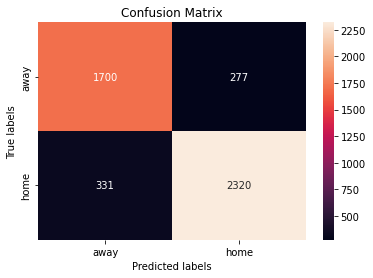

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

#labels = ['0-4%', '4-7.6%']
CM = confusion_matrix(results_compared['target_class'], results_compared['prediction'])

ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['away', 'home']); ax.yaxis.set_ticklabels(['away', 'home']);

### roc curve - away class

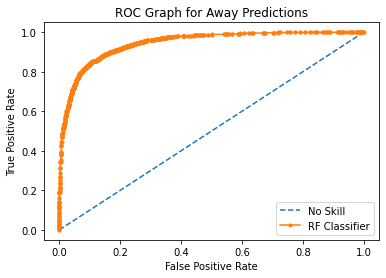

RF Classifier ROC AUC 0.945


In [38]:
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve


## retrieve probabliities for 
probabilities = rf_clf.predict_proba(X_adj_bucket)
away_prob = probabilities[:,-2]
home_prob = probabilities[:,-1]

# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_adj_bucket, away_prob, pos_label='away')
# plot no skill roc curve
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='RF Classifier')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
## show chart title
pyplot.title('ROC Graph for Away Predictions')
# show the plot
pyplot.show()

# calculate roc auc
roc_auc = roc_auc_score(y_adj_bucket, rf_clf.predict_proba(X_adj_bucket)[:, 1])
print('RF Classifier ROC AUC %.3f' % roc_auc)

### roc curve - home class

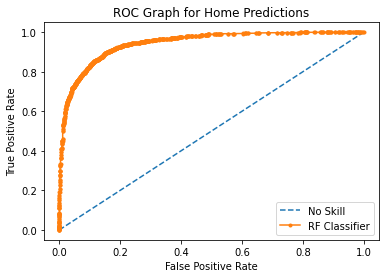

RF Classifier ROC AUC 0.945


In [39]:
## retrieve probabliities for 
probabilities = rf_clf.predict_proba(X_adj_bucket)
away_prob = probabilities[:,-2]
home_prob = probabilities[:,-1]

# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_adj_bucket, home_prob, pos_label='home')
# plot no skill roc curve
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='RF Classifier')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
## show chart title
pyplot.title('ROC Graph for Home Predictions')
# show the plot
pyplot.show()

# calculate roc auc
roc_auc = roc_auc_score(y_adj_bucket, rf_clf.predict_proba(X_adj_bucket)[:, -1])
print('RF Classifier ROC AUC %.3f' % roc_auc)

### precision recall curve - away

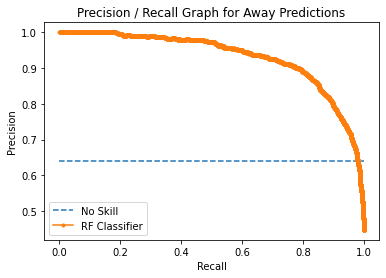

In [40]:
# calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_adj_bucket, away_prob, pos_label='away')

# calculate the no skill line as the proportion of the positive class
no_skill = .64
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='RF Classifier')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
## show chart title
pyplot.title('Precision / Recall Graph for Away Predictions')
# show the plot
pyplot.show()

### precision recall curve - home

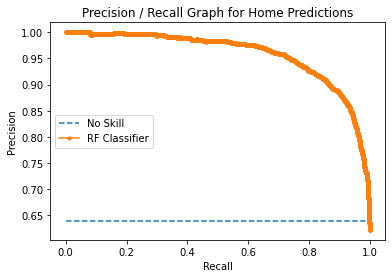

In [41]:
# calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_adj_bucket, home_prob, pos_label='home')

# calculate the no skill line as the proportion of the positive class
no_skill = .64
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='RF Classifier')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
## show chart title
pyplot.title('Precision / Recall Graph for Home Predictions')
# show the plot
pyplot.show()

### looking to see if the model is maintaining balance of predicting each class via precision, recall, and f-1 score.

In [42]:
from sklearn.metrics import recall_score, precision_score, f1_score
print(precision_score(y_adj_bucket, y_pred['prediction'], pos_label='away'))
print(recall_score(y_adj_bucket, y_pred['prediction'], pos_label='away'))
print(f1_score(y_adj_bucket, y_pred['prediction'], pos_label='away'))

0.8370260955194485
0.8598887202832575
0.8483033932135728


In [43]:
print(precision_score(y_adj_bucket, y_pred['prediction'], pos_label='home'))
print(recall_score(y_adj_bucket, y_pred['prediction'], pos_label='home'))
print(f1_score(y_adj_bucket, y_pred['prediction'], pos_label='home'))

0.8933384674624567
0.8751414560543191
0.8841463414634148


In [44]:
results_compared['incorrect_flag'] = np.where(results_compared['prediction'] != results_compared['target_class'], 1,0)
incorrect_predictions = results_compared[results_compared['incorrect_flag'] == 1]
incorrect_predictions

,target_class,prediction,away,home,incorrect_flag
1,away,home,0.221187,0.778813,1
32,away,home,0.216439,0.783561,1
33,away,home,0.146974,0.853026,1
36,home,away,0.581588,0.418412,1
48,home,away,0.565676,0.434324,1
...,...,...,...,...,...
4567,away,home,0.497233,0.502767,1
4568,home,away,0.559393,0.440607,1
4578,away,home,0.329288,0.670712,1
4582,away,home,0.326928,0.673072,1


### lets take a look under the hood a bit with shap

In [47]:
# compute SHAP values
explainer = shap.TreeExplainer(rf_clf, X_adj_bucket, check_additivity=False)
shap_values = explainer.shap_values(X_adj_bucket, check_additivity=False)

In [48]:
explainer.expected_value

array([0.41144124, 0.58855876])

#### - the first value in this array is the base probability for an "away" prediction, this leaving the second to be a "home" prediction.

#### - So without looking at any of the game statistics we would expect 58.8% of the time the home team will win. Interesting when we hear Home stadium advantage is such a big advantage. This data set is already telling us exactly that.

In [49]:
def Average(lst):
    return sum(lst) / len(lst)

## average
shap_values_dict = dict(zip(X_adj_bucket.columns, Average(shap_values[0])))

## sum
#shap_values_dict = dict(zip(X_adj.columns, sum(shap_values)))

shap_values_dict

{'first_downs_away': 0.0002643739459753917,
 'first_downs_home': 0.00010288676736382704,
 'passing_yards_away': 0.0003488621004682443,
 'passing_yards_home': 0.00018148757721995367,
 'rushing_yards_away': -0.0011837154400803117,
 'rushing_yards_home': 0.0009647942549743655,
 'total_yards_away': 0.0013352732499630068,
 'total_yards_home': 0.0006648000806738906,
 'rushing_attempts_away': 0.005722688176173453,
 'rushing_attempts_home': 0.004502628234155479,
 'fumbles_away': 0.0009974380298772207,
 'fumbles_home': -4.3834429458990885e-05,
 'int_away': 0.006304016458165908,
 'int_home': 0.0003559565762638553,
 'turnovers_away': 0.011509880763349882,
 'turnovers_home': -0.00043770469299648715,
 'drives_away': 0.00014582035812686544,
 'drives_home': -4.276170890708599e-05,
 'def_st_td_away': 0.0012373162144485408,
 'def_st_td_home': 0.0010609541304713419,
 'possession_away': 0.0016077797766504748,
 'possession_home': -0.002556946415338721,
 'third_down_conversion': 0.000607526051521237,
 'thi

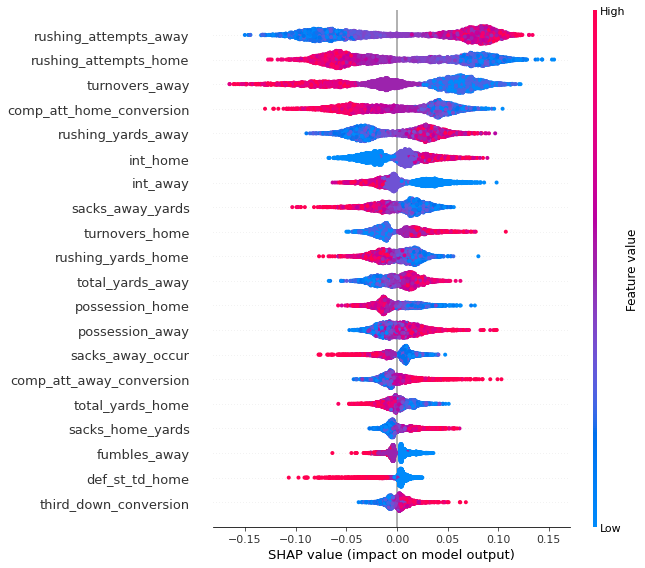

In [50]:
shap.summary_plot(shap_values[0], X_adj_bucket, plot_type='dot')

### shap force plots

In [51]:
#shap.initjs()

#shap.force_plot(explainer.expected_value[0], shap_values[0], X_adj_bucket)

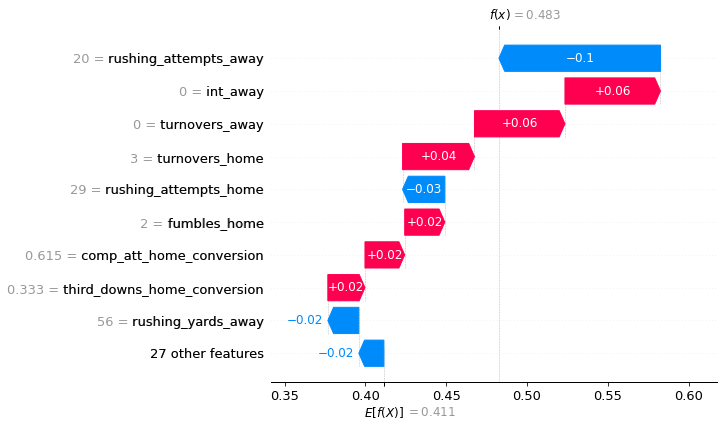

In [52]:
from shap import Explanation

## this would be looking at the shap values for the most recent prediction
shap.waterfall_plot(Explanation(shap_values[0][-1],explainer.expected_value[0], data=X_adj_bucket.iloc[-1], feature_names=X_adj_bucket.columns))

## Model Type - Logistic

In [64]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='liblinear')
np.random.seed(42)

In [66]:
x_train, x_test, y_train, y_test = train_test_split(X_adj_bucket, y_adj_bucket, random_state=42, test_size=.3, shuffle=True)

##smote
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

##random oversample
#ros = RandomOverSampler(random_state=42)
#x_train_res, y_train_res = ros.fit_resample(x_train, y_train)

log_classifier = log_reg.fit(x_train_res, y_train_res)
#log_reg.fit(x_train, y_train)
print("Training Set Score:", log_reg.score(x_train_res, y_train_res))
#print(log_reg.score(x_train, y_train))
print("Testing Set Score:",log_reg.score(x_test, y_test))

## saving model
# save the model to disk
filename = 'models/log_reg_model_1.sav'
pickle.dump(log_classifier, open(filename, 'wb'))

# load the model from disk
log_reg = pickle.load(open(filename, 'rb'))

Training Set Score: 0.9107625743645213
Testing Set Score: 0.8934485241180705


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [67]:
from sklearn.metrics import classification_report

y_pred_train = log_reg.predict(x_train)
#y_pred_train = log_reg.predict(x_train_res)
y_pred_test = log_reg.predict(x_test)

# View the classification report for test data and predictions
print("Training Classification Metrics")
print(classification_report(y_train, y_pred_train))
#print(classification_report(y_train_res, y_pred_train))
print("Testing Classification Metrics")
print(classification_report(y_test, y_pred_test))

Training Classification Metrics
              precision    recall  f1-score   support

        away       0.88      0.89      0.88      1390
        home       0.91      0.91      0.91      1849

    accuracy                           0.90      3239
   macro avg       0.90      0.90      0.90      3239
weighted avg       0.90      0.90      0.90      3239

Testing Classification Metrics
              precision    recall  f1-score   support

        away       0.87      0.88      0.88       587
        home       0.91      0.90      0.91       802

    accuracy                           0.89      1389
   macro avg       0.89      0.89      0.89      1389
weighted avg       0.89      0.89      0.89      1389



In [68]:
y_pred = pd.DataFrame(log_reg.predict(X_adj_bucket), columns=['prediction'],index=X_adj_bucket.index)
probabilities_log_reg = pd.DataFrame(log_reg.predict_proba(X_adj_bucket), columns=['away', 'home'],index=X_adj_bucket.index)
#plt.plot(y_adj.index,y_adj)
#plt.plot(y_adj.index, y_pred)
#plt.legend([y_adj.name, y_pred.columns[0]])
#plt.gca().legend(('Actual','Predicted'))
probabilities_log_reg.tail()

,away,home
4623,0.157292,0.842708
4624,0.006899,0.993101
4625,0.985028,0.014972
4626,0.994902,0.005098
4627,0.613451,0.386549


In [69]:
print('Metrics for Class: "away"')
print("Precision Score:",precision_score(y_adj_bucket, y_pred['prediction'], pos_label='away'))
print("Recall Score:",recall_score(y_adj_bucket, y_pred['prediction'], pos_label='away'))
print("F1 Score:",f1_score(y_adj_bucket, y_pred['prediction'], pos_label='away'))

Metrics for Class: "away"
Precision Score: 0.8773159739609414
Recall Score: 0.8861911987860395
F1 Score: 0.8817312531454454


In [70]:
print('Metrics for Class: "home"')
print("Precision Score:",precision_score(y_adj_bucket, y_pred['prediction'], pos_label='home'))
print("Recall Score:",recall_score(y_adj_bucket, y_pred['prediction'], pos_label='home'))
print("F1 Score:",f1_score(y_adj_bucket, y_pred['prediction'], pos_label='home'))

Metrics for Class: "home"
Precision Score: 0.9144811858608894
Recall Score: 0.907582044511505
F1 Score: 0.9110185535781901


In [71]:
results = pd.concat([y_pred, y_adj_bucket, probabilities_log_reg], axis=1).sort_index()
results.tail(20)

,prediction,target_class,away,home
4608,home,home,0.081579,0.918421
4609,home,home,0.002416,0.997584
4610,away,away,0.821592,0.178408
4611,home,away,0.346464,0.653536
4612,away,away,0.990692,0.009308
4613,home,home,0.000007,0.999993
4614,home,home,0.000698,0.999302
4615,away,away,0.998937,0.001063
4616,away,away,0.992274,0.007726
4617,away,away,0.968533,0.031467


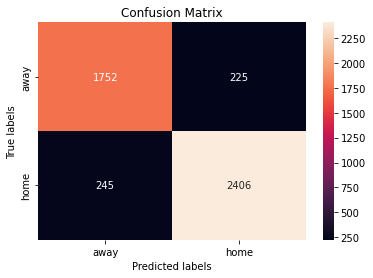

In [72]:
#labels = ['0-4%', '4-7.6%']
CM = confusion_matrix(y_adj_bucket, y_pred['prediction'])

ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['away', 'home']); ax.yaxis.set_ticklabels(['away', 'home']);

### Model Type - Logistic Regression w/ smote & recursive feature elemination

In [89]:
log_reg = LogisticRegression(solver='liblinear')
np.random.seed(42)

In [91]:
from sklearn.feature_selection import RFE, SelectFromModel

x_train, x_test, y_train, y_test = train_test_split(X_adj_bucket, y_adj_bucket, random_state=42, test_size=.3, shuffle=True)

##smote
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

##random oversample
#ros = RandomOverSampler(random_state=42)
#x_train_res, y_train_res = ros.fit_resample(x_train, y_train)

## RFE
predictors = x_train_res
log_classifier_selector = RFE(log_reg, n_features_to_select=20)
log_classifier_selector = log_classifier_selector.fit(predictors, y_train_res)

## sfm
#log_classifier_selector = SelectFromModel(log_reg, threshold=np.inf, max_features=15)
#log_classifier_selector = log_classifier_selector.fit(x_train_res, y_train_res)

## just using SMOTE
#log_classifier = log_reg.fit(x_train_res, y_train_res)
#log_reg.fit(x_train, y_train)

print("Training Set Score:", log_classifier_selector.score(x_train_res, y_train_res))
#print(log_reg.score(x_train, y_train))
print("Testing Set Score:",log_classifier_selector.score(x_test, y_test))

## saving model
# save the model to disk
filename = 'models/log_reg_fs_model_2.sav'
pickle.dump(log_classifier_selector, open(filename, 'wb'))

# load the model from disk
log_classifier_selector = pickle.load(open(filename, 'rb'))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Training Set Score: 0.8783126014061655
Testing Set Score: 0.8560115190784737


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [92]:
order = log_classifier_selector.ranking_
order

array([15, 12,  1,  1,  1,  1,  1,  1,  3,  8,  1,  1,  1,  1,  1,  1,  6,
        7,  1,  1,  2,  9,  1,  1,  1,  1,  1,  1,  4, 17, 11, 16, 10, 14,
        5, 13])

In [86]:
importance = log_classifier_selector.get_support()
importance

array([False, False,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True, False, False,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False])

In [87]:
feature_ranks = []

for i in order:
    feature_ranks.append(f"{i}. {predictors.columns[i]}")

feature_ranks

['15. turnovers_home',
 '12. int_away',
 '1. first_downs_home',
 '1. first_downs_home',
 '1. first_downs_home',
 '1. first_downs_home',
 '1. first_downs_home',
 '1. first_downs_home',
 '3. passing_yards_home',
 '8. rushing_attempts_away',
 '1. first_downs_home',
 '1. first_downs_home',
 '1. first_downs_home',
 '1. first_downs_home',
 '1. first_downs_home',
 '1. first_downs_home',
 '6. total_yards_away',
 '7. total_yards_home',
 '1. first_downs_home',
 '1. first_downs_home',
 '2. passing_yards_away',
 '9. rushing_attempts_home',
 '1. first_downs_home',
 '1. first_downs_home',
 '1. first_downs_home',
 '1. first_downs_home',
 '1. first_downs_home',
 '1. first_downs_home',
 '4. rushing_yards_away',
 '17. drives_home',
 '11. fumbles_home',
 '16. drives_away',
 '10. fumbles_away',
 '14. turnovers_away',
 '5. rushing_yards_home',
 '13. int_home']